# MOSFET Current Mirror Analysis

By: Gabriel DiMartino, Michael Baker, Elijah Chin

![EENG304L Lab 7 Schematic.png](<attachment:EENG304L Lab 7 Schematic.png>)
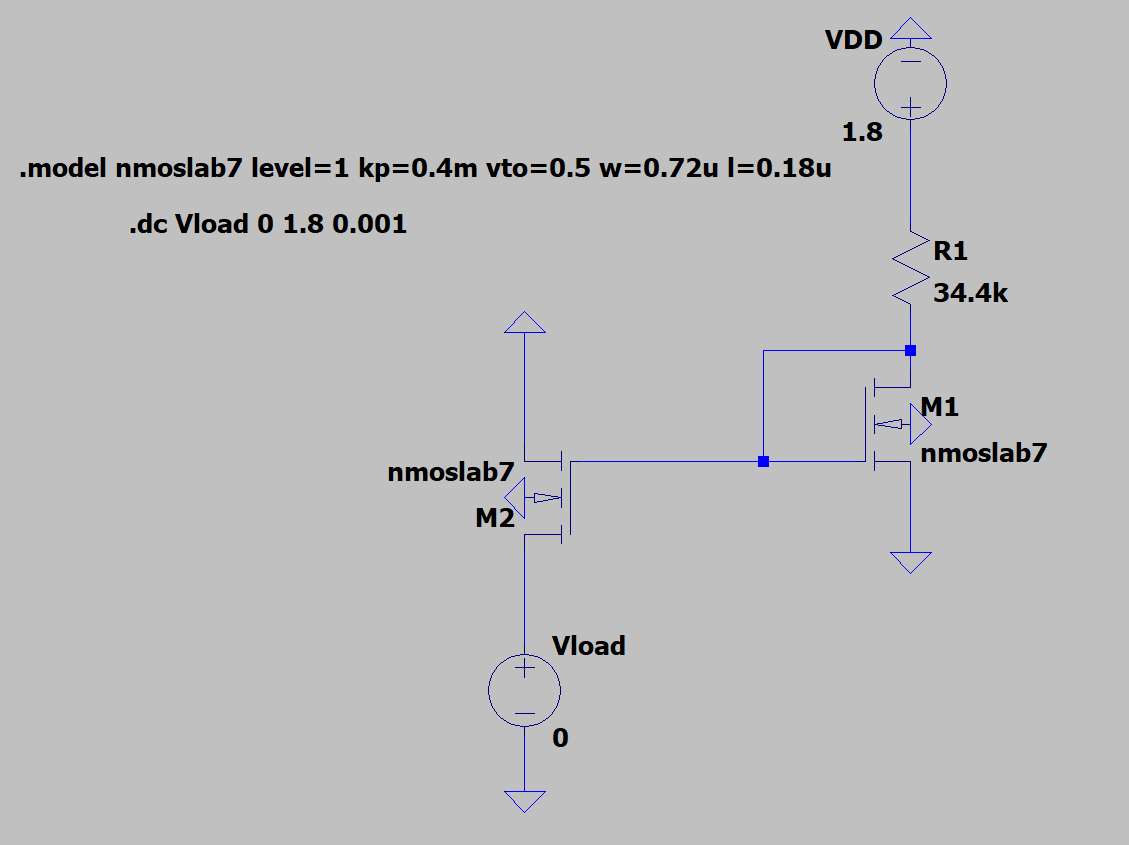

In [15]:
%pip install -q numpy matplotlib PyLTSpice==3.1.0;

Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PyLTSpice import RawRead

## Retrieve Traces From Spice
For the Spice simulation analysis, we retrieve the necessary traces as follows:

* For $V_{DS2}$, we extract the VLoad voltage trace.
* For $I_{DS2}$ and $I_{REF}$, we measure the drain currents flowing through their respective MOSFETs.
* For $V_{VGS}$, we measure the voltage at the gate and source. This value should be the same for both MOSFETs.

These traces provide all the required data to analyze the current mirror's compliance range and operational regions.

In [17]:
try:
    file_path = "./spice_info/EENG304L Lab7.raw"
    LTS = RawRead(file_path)
    print(f"Successfully loaded {file_path}")
    
    v_ds2 = np.array(LTS.get_trace("Vload"))
    i_ds2 = np.array(LTS.get_trace("Id(M2)"))
    i_ref = np.array(LTS.get_trace("Id(M1)"))[0]
    v_gs = np.array(LTS.get_trace("V(n002)"))[0]
    
    print(f"Successfully extracted V_DS2 (using {v_ds2}) and I_DS2 (using {i_ds2})")
except Exception as e:
    print(f"Error loading the file: {e}")


Reading file with encoding  utf_16_le
File contains 15 traces, reading 15
Binary RAW file with Normal access
Successfully loaded ./spice_info/EENG304L Lab7.raw
Successfully extracted V_DS2 (using [0.000e+00 1.000e-03 2.000e-03 ... 1.798e+00 1.799e+00 1.800e+00]) and I_DS2 (using [0.0000000e+00 3.1909337e-07 6.3658678e-07 ... 3.1978685e-05 3.1978685e-05
 3.1978685e-05])


## Determining the Saturation Boundary
For our current mirror circuit:
1. The threshold voltage ($V_{TH}$) is known from device parameters as 0.5V
2. The gate-source voltage ($V_{GS}$) is established by the reference transistor (M1)
3. The saturation boundary is calculated as $V_{DS2,sat} = V_{GS} - V_{TH}$

This boundary marks the minimum drain-source voltage required for the mirror transistor to maintain constant current output regardless of changes in drain voltage.


In [18]:

V_TH = 0.5

v_ds_sat = v_gs - V_TH

# Find indices where transistor is in saturation (v_ds2 >= v_ds_sat)
saturation_indices = np.where(v_ds2 >= v_ds_sat)[0]
non_saturation_indices = np.where(v_ds2 < v_ds_sat)[0]

print(f"Theoretical saturation boundary: V_DS2,sat = {v_ds_sat:.2f} V")
if len(saturation_indices) > 0:
    sat_start_idx = np.min(saturation_indices)
    sat_start_vds = v_ds2[sat_start_idx]
    print(f"In simulation data, current mirror enters saturation at V_DS2 = {sat_start_vds:.2f} V")
    

Theoretical saturation boundary: V_DS2,sat = 0.20 V
In simulation data, current mirror enters saturation at V_DS2 = 0.20 V


## Operational Analysis
When $V_{DS2} < V_{DS2,sat}$:
- The mirror transistor operates in the triode (linear) region
- Current varies significantly with changes in $V_{DS2}$
- Mirror accuracy is compromised

When $V_{DS2} \geq V_{DS2,sat}$:
- The mirror transistor operates in saturation
- Current remains stable and closely matches $I_{REF}$
- The mirror functions as intended

The plot clearly demonstrates this behavior, with the mirror current stabilizing at $V_{DS2,sat}$ and maintaining that stability throughout the saturation region.

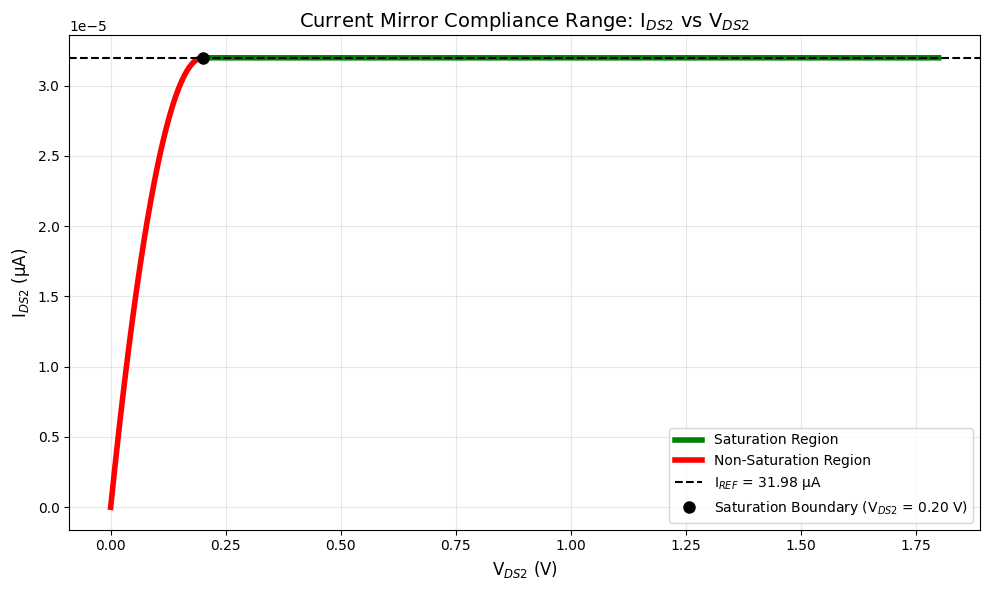

In [19]:
plt.figure(figsize=(10, 6))

def convert_units(value):
    if abs(value) < 1e-9:
        return value * 1e12, 'pA'
    elif abs(value) < 1e-6:
        return value * 1e9, 'nA'
    elif abs(value) < 1e-3:
        return value * 1e6, 'µA'
    elif abs(value) < 1:
        return value * 1e3, 'mA'
    else:
        return value, 'A'

i_ref_converted, i_unit = convert_units(i_ref)
i_ds2_converted, i_unit = convert_units(np.max(i_ds2))

i_ds2_plot, _ = zip(*[convert_units(i) for i in i_ds2])

# Plot the entire I_DS2 vs V_DS2 curve without adding to legend
plt.plot(v_ds2, i_ds2, 'b-', linewidth=2)
    
# Highlight saturation and non-saturation regions
if len(saturation_indices) > 0:
    plt.plot(v_ds2[saturation_indices], i_ds2[saturation_indices], 'g-', linewidth=4, 
             label='Saturation Region')
    
if len(non_saturation_indices) > 0:
    plt.plot(v_ds2[non_saturation_indices], i_ds2[non_saturation_indices], 'r-', linewidth=4, 
             label='Non-Saturation Region')
    
plt.axhline(y=i_ref, color='k', linestyle='--', 
            label=f'I$_{{REF}}$ = {i_ref_converted:.2f} {i_unit}')
    
# Find the boundary point where the mirror enters saturation
if len(saturation_indices) > 0 and len(non_saturation_indices) > 0:
    first_sat_idx = np.min(saturation_indices)
    v_sat = v_ds2[first_sat_idx]
    plt.plot(v_sat, i_ds2[first_sat_idx], 'ko', markersize=8,
             label=f'Saturation Boundary (V$_{{DS2}}$ = {v_sat:.2f} V)')
    
# Set axis labels and title with proper subscripts
plt.xlabel('V$_{DS2}$ (V)', fontsize=12)
plt.ylabel(f'I$_{{DS2}}$ ({i_unit})', fontsize=12)
plt.title('Current Mirror Compliance Range: I$_{DS2}$ vs V$_{DS2}$', fontsize=14)
    
# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
    
# Show the plot
plt.tight_layout()
plt.savefig('current_mirror_compliance_range.png', dpi=300)
plt.show()

## Compliance Range
The compliance range of the current mirror is defined as the range of output voltages over which the mirror can maintain accurate current copying. This corresponds to the range:

$V_{DS2,sat} \leq V_{DS2} \leq V_{DD,max}$

Our analysis provides the lower bound of this range, which is essential for proper circuit design and operation.

In [20]:
min_vds_sat = np.min(v_ds2[saturation_indices])
max_vds = np.max(v_ds2)
compliance_range = max_vds - min_vds_sat
print(f"Compliance Range: {min_vds_sat:.4f} V to {max_vds:.4f} V ({compliance_range:.4f} V)")

Compliance Range: 0.2000 V to 1.8000 V (1.6000 V)
